In [ ]:
# gpu 사용여부 확인

!nvidia-smi

Thu Jan 28 02:45:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 필요한 라이브러리 가져오기

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [ ]:
# 드라이브 접근 ( 데이터 및 코드 파일이 드라이브에 있었음 )
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 데이터 확인

* 주제 : 마스크 착용 여부 확인
* 데이터 출처 : https://arxiv.org/abs/2008.08016
* 데이버 분류 방법 : 3가지로 분류
  - 빨강 : 미착용 / 노랑 : 부적절한 착용 / 초록 : 적절한 착용

In [ ]:
# 데이터 확인

print("The number of images with facemask labelled 'Green':",len(os.listdir('/content/drive/MyDrive/covid/data/green')))
print("The number of images with facemask labelled 'Yellow':",len(os.listdir('/content/drive/MyDrive/covid/data/yellow')))
print("The number of images with facemask labelled 'Red':",len(os.listdir('/content/drive/MyDrive/covid/data/red')))

The number of images with facemask labelled 'Green': 1916
The number of images with facemask labelled 'Yellow': 1893
The number of images with facemask labelled 'Red': 1897


*** 기존 파일이 green, yellow, red 로 3개로 분류되어있어서, 
training data와 validation data, test data로 나누기 위한 코드

In [ ]:
import os
import numpy as np
import shutil
import random

root_dir = '/content/drive/MyDrive/covid/data/' # data root path
classes_dir = ['green', 'yellow', 'red'] #total labels

# 80% , 17%, 3%의 비율로 데이터를 나눔

val_ratio = 0.17
test_ratio = 0.03

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)
    os.makedirs(root_dir +'test/' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                              int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)

# The number of images with facemask labelled 'Green': 1916
# The number of images with facemask labelled 'Yellow': 1893
# The number of images with facemask labelled 'Red': 1897

Total images:  1916
Training:  1532
Validation:  326
Testing:  58
Total images:  1893
Training:  1514
Validation:  322
Testing:  57
Total images:  1897
Training:  1517
Validation:  323
Testing:  57


In [ ]:
# train_data, val_data, test_data로 사진이 잘 나누어져서 저장되었는지 확인 

base_dir = '/content/drive/MyDrive/covid/data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


train_green_dir = os.path.join(train_dir, 'green')
train_yellow_dir = os.path.join(train_dir, 'yellow')
train_red_dir = os.path.join(train_dir, 'red')


val_green_dir = os.path.join(val_dir, 'green')
val_yellow_dir = os.path.join(val_dir, 'yellow')
val_red_dir = os.path.join(val_dir, 'red')

green_files = os.listdir(train_green_dir)
print(green_files[:10])

yellow_files = os.listdir(train_yellow_dir)
print(yellow_files[:10])

red_files = os.listdir(train_red_dir)
print(red_files[:10])

['02994_Mask.jpg', '18869_Mask.jpg', '18919_Mask.jpg', '18926_Mask.jpg', '02441_Mask.jpg', '02915_Mask.jpg', '02928_Mask.jpg', '02159_Mask.jpg', '18001_Mask.jpg', '02309_Mask.jpg']
['12190_Mask_Mouth_Chin.jpg', '00171_Mask_Mouth_Chin.jpg', '00989_Mask_Mouth_Chin.jpg', '00081_Mask_Chin.jpg', '12704_Mask_Mouth_Chin.jpg', '00084_Mask_Mouth_Chin.jpg', '12149_Mask_Mouth_Chin.jpg', '00928_Mask_Nose_Mouth.jpg', '12402_Mask_Mouth_Chin.jpg', '00672_Mask_Mouth_Chin.jpg']
['10675.png', '281.jpg', '37583.png', '10660.png', '37267.png', '374.jpg', '10668.png', '37673.png', '37421.png', '37573.png']


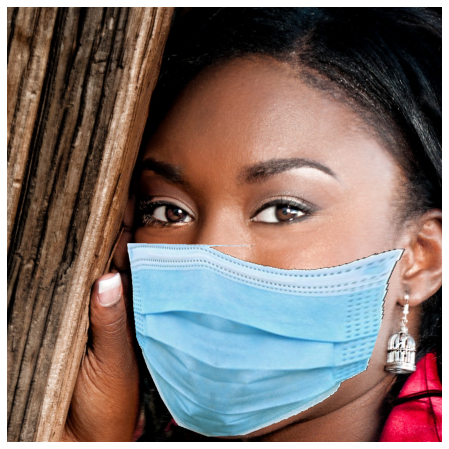

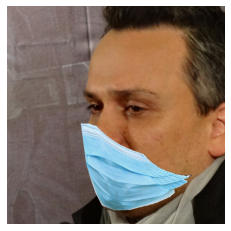

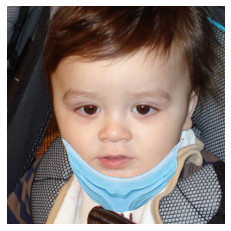

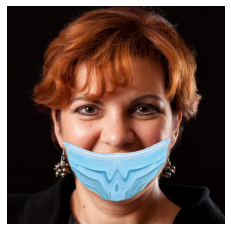

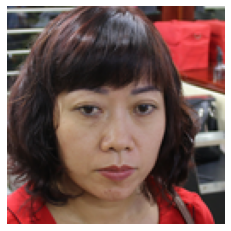

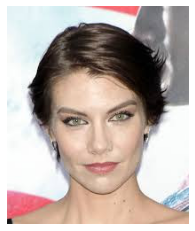

In [ ]:
# 사진 확인용 코드

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 2*2 configuration
nrows = 2
ncols = 2

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=2

next_green = [os.path.join(train_green_dir, fname) 
                for fname in green_files[pic_index-2:pic_index]]
next_yellow = [os.path.join(train_yellow_dir, fname) 
                for fname in yellow_files[pic_index-2:pic_index]]
next_red = [os.path.join(train_red_dir, fname) 
                for fname in red_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_green+next_yellow+next_red):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [ ]:
# 사진 데이터 딥러닝 모델
# CNN 기법 활용

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# 정면 사진을 다양한 형태로 변형시켜 데이터를 풍부하게 만듦 (회전, 비틀림, 확대, 축소 등)
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

# input 데이터를 150*150 사이즈로 변환
# 따라서 이 모델에 테스트 하기 위해 사진을 넣어볼 땐 사이즈 조정을 해주어야 한다

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',                
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(150,150),
	class_mode='categorical',            
  batch_size=126
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')            
])

# 3가지 분류 방법이기 때문에 softmax 활성 함수 사용

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 

history = model.fit(train_generator, epochs=30, steps_per_epoch=20, 
                    validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("mask_epoch30_v1.h5")

Found 4563 images belonging to 3 classes.
Found 971 images belonging to 3 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_____________________________________

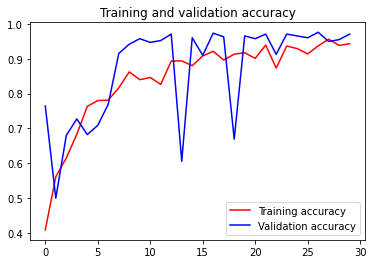

<Figure size 432x288 with 0 Axes>

In [ ]:
# 모델의 Loss와 Accuracy 확인

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# 사진을 업로드해서 모델 확인


import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys(): # 이 구문 때문에 여러사진을 한번에 확인 가능
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)
  plt.figure()
  plt.imshow(img)
  plt.show()

  # 순서 : [green,red,yellow]

Saving mask.jpg to mask (1).jpg
mask.jpg
[[0.03804459 0.         0.9619554 ]]


In [ ]:
# 모델 저장 코드
model.save("/content/drive/MyDrive/covid/mask_epoch30_v1.h5")